In [13]:
%matplotlib inline

import h5py
import numpy as np
import pylab as plt

In [16]:
h5 = h5py.File("LP9915_LZFcompression_PYTHONONLY_WIDE_uint16.h5py","r")

## Callibration of detector distance

In [11]:
# we mesured water scattering at several time fluence values and pump probe delays

# we did not callibrate the experimental geometry, so we attempt to do it here using standard trig

# We measured rhodopsin scattering at multiple detector distances

# If we assume the detector position motor value in the data stream is callibrated to units of 
# millimeters (it should be!), then we can use that to determine the precise detector distance



In [31]:
# lets pick a random run at detector position 1
data1 = h5["ALL_RUN_DATA"]["run153"] # closer detector pos
data2 = h5["ALL_RUN_DATA"]["run227"] # further detector pos

In [32]:
def get_dark(data):
    pump = data["pump"].value
    probe = data["probe"].value
    is_dark = np.logical_and(probe , ~pump)
    darks = data["radialprofiles"].value[is_dark]
    return darks
    

In [39]:
darks1 = get_dark(data1)
darks2 = get_dark(data2)

darks1_mean = darks1.mean(0)
darks2_mean = darks2.mean(0)

(50, 1200)

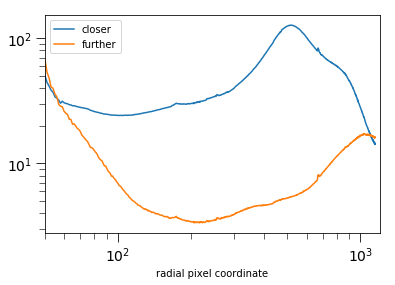

In [48]:
plt.plot( darks1_mean, label="closer")
plt.plot( darks2_mean, label="further")
plt.legend()
plt.xlabel("radial pixel coordinate")
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.gca().tick_params(which='minor', length=6)
plt.gca().tick_params(which='major', length=9)

plt.gca().tick_params(labelsize=14)
plt.xlim(50,1200)

In [43]:
# from thos plot above it looks like we can 
# extract the water-peak position of the mean profile in either case


(50, 1200)

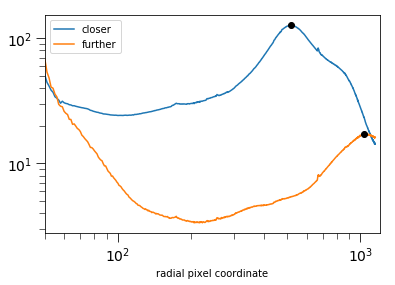

In [144]:
pos1 = np.arange( 420,620) # peak is within this range
pk1 = np.argmax( darks1_mean[pos1]) + pos1[0]

pos2 = np.arange( 700,len( darks2_mean)) # peak is within this range
pk2 = np.argmax( darks2_mean[pos2]) + pos2[0]


plt.plot( darks1_mean, label="closer")
plt.plot( pk1, darks1_mean[pk1], 'ko')
plt.plot( darks2_mean, label="further")
plt.plot( pk2, darks2_mean[pk2], 'ko')
plt.legend()
plt.xlabel("radial pixel coordinate")
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.gca().tick_params(which='minor', length=6)
plt.gca().tick_params(which='major', length=9)

plt.gca().tick_params(labelsize=14)
plt.xlim(50,1200)


In [145]:
# Now, a bit of psana, we need to get the detector slider readout during both of these runs
# then we can use a bit of geometry to pinpoint solve for detector distance

# The EPICS reading are (from the Elog, DscCsPad_z) from pswww.slac.stanford.edu Elog
det1_z = -449.9904
det2_z = -305.9764

delta_z = det2_z - det1_z # this should be in mm!
print(delta_z)

144.014


In [146]:
# lets convert all our units to SI
delta_z = delta_z / 1000. # convert mm to meter
r1 = pk1*0.00011 # pixel size is 110 micron
r2 = pk2*0.00011 #''


Text(0.5,0,'$2\\theta$')

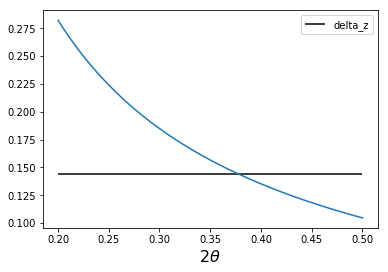

In [147]:
# from standard trig it follows that
# delta_z = r2 / tan(2theta) - r1/tan(2theta)

# we can solve this equation graphically for 2theta
twothetas = np.linspace(0.2, 0.5, 1000)
plt.plot( twothetas, r2/np.tan(twothetas) - r1/np.tan(twothetas) )
plt.hlines( delta_z, twothetas[0], twothetas[-1], label='delta_z')
plt.legend()
plt.xlabel(r"$2\theta$", fontsize=16)

In [148]:
min_twotheta_idx = np.argmin( np.abs( r2/np.tan(thetas) - r1/np.tan(thetas)  - delta_z))
twotheta = twothetas[min_twotheta_idx]
print ("Minimum 2theta value is %.4f rad."%twotheta) 


Minimum 2theta value is 0.3781 rad.


In [149]:
# from this we 1) now know the peak position for rhodopsin scattering and 
#   2) know the precise detector distances

detdist1 = r1/np.tan(twotheta)
detdist2 = r2/np.tan( twotheta)
print ("Detector distance 1,2 are %.3f, %.3f meter, respectively. "%( detdist1, detdist2))

Detector distance 1,2 are 0.143, 0.287 meter, respectively. 


In [150]:
import loki
from loki.utils.postproc_helper import smooth

In [151]:
# Now that we have these values, we can look at the water scattering curve
# and calibrate the Q-scale

data_water = h5["ALL_RUN_DATA"]["run72"]
darks_water = get_dark( data_water)
rads = np.arange(0, darks_water.shape[1])
wavelen = 1.305
qs =  np.sin( np.arctan( rads * .00011/ detdist1 )*.5 ) * 4 * np.pi / wavelen
darks_water_mean = smooth( darks_water.mean(0), window_size=30)

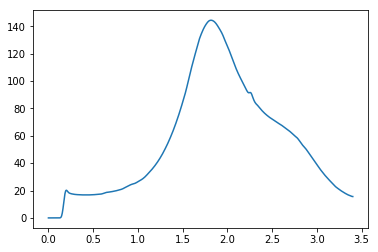

In [152]:
plt.plot( qs, darks_water_mean )

In [153]:
water_peak = qs[ np.argmax(darks_water_mean ) ]
print("The water peak in the dark profiles is at %.4f inverse Angstrom!"%water_peak)

The water peak in the dark profiles is at 1.8189 inverse Angstrom!


In [168]:
# we can put a bound on this
detdist_low = 0.125
qs_low =  np.sin( np.arctan( rads * .00011/ detdist_low )*.5 ) * 4 * np.pi / wavelen
water_peak_low = qs_low[ np.argmax(darks_water_mean ) ]
print("The water peak lower bound in the dark profiles is at %.4f inverse Angstrom!"%water_peak_low)

The water peak lower bound in the dark profiles is at 2.0539 inverse Angstrom!
